# Análise de Sentimento com Regressão Logística

### Carregando as Dependências do Projeto

In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
import numpy as np
import shap
import nltk
from nltk.stem import RSLPStemmer
from nltk.stem.porter import *
from sklearn.metrics import f1_score

shap.initjs()

### Carregando o Conjunto de Dados

In [2]:
corpus,y = shap.datasets.imdb()

## Stemização
Consiste em reduzir uma palavra ao seu radical

In [3]:
stemmer = PorterStemmer()
stemmed = nltk.stem.SnowballStemmer("english")
new_corpus = []

for frase in corpus:
  frases_stemming = '' 
  for palavras in frase.split():
    frases_stemming += str(stemmer.stem(palavras.lower())) + " "
  new_corpus.append(frases_stemming)
  frases_stemming = ''

### Construindo Amostras de Treinamento e Testes e Remoção de Stopwords

In [4]:
corpus_train, corpus_test, y_train, y_test = train_test_split(new_corpus, y, test_size=0.2, random_state=7)

my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])
vectorizer = TfidfVectorizer(stop_words=my_stop_words,min_df=10)

X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)


### Treinando um Modelo de Regressão Linear 
* Validação cruzada para o melhor C e melhor Penalty

In [22]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

logreg = LogisticRegression()
logreg_cv= GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)


/home/joao/anaconda3/envs/dados/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8788


In [13]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Construindo o explicador SHAP

In [14]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

### Sumarizando o efeito das features

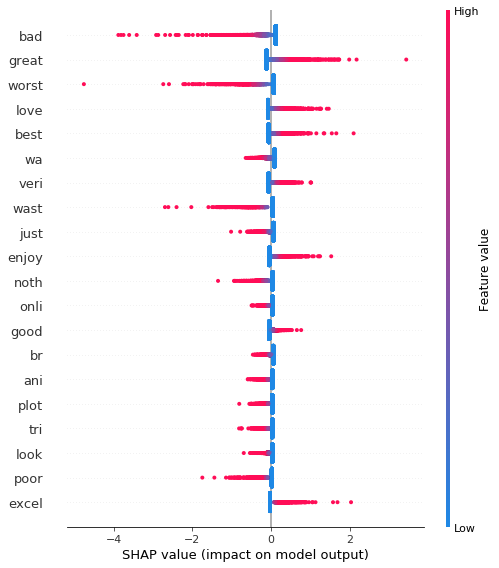

In [15]:
shap.summary_plot(shap_values, X_test_array, feature_names= vectorizer.get_feature_names())

# Positive Review:

In [16]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

# Negative Review:

In [17]:
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [19]:
y_prediction = model.predict(X_test)
f1 = f1_score(y_prediction, y_test, average='weighted')
print(f1)

0.8812159847661616


### Precisão 88.1% 

## Floresta aleatória
Uma árvore de decisão é uma ferramenta de apoio à decisão que usa um gráfico de árvore ou modelo de decisões e suas possíveis consequências.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score


In [46]:
clf_rf = RandomForestClassifier(random_state=100)      
clr_rf = clf_rf.fit(X_train,y_train)

/home/joao/anaconda3/envs/dados/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [56]:
ac = accuracy_score(y_test,clf_rf.predict(X_test))
print('Accuracy is: ',ac)

Accuracy is:  0.746


## Precisão de 74.6 % 

## Usando GridSearchCV para encontrar os melhores parâmetros

In [48]:
rfc=RandomForestClassifier(random_state=42)

In [49]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [50]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [51]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 500}

In [52]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=7, criterion='gini')

In [53]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [55]:
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8228


## Precisão de 82.2 % 